In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

# Generate data

In [4]:
iris = load_iris()
data = iris.data[:, :2] # Select first 2 features from all the columns available.
labels = iris.target

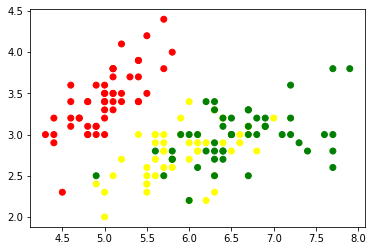

In [5]:
plt.scatter( data[:, 0], data[:, 1], c= labels, cmap = my_cmap)
plt.show()

In [6]:
print("Data shape",data.shape)
print("Labels shape",labels.shape)

Data shape (150, 2)
Labels shape (150,)


# MultiClass Classification

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0,test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(120, 2) (30, 2) (150,)


In [8]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(120, 3) (30, 3)


# FFN

In [9]:
class FFNetwork:

    def __init__(self, num_hidden=2, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.01 ):

        self.params = {}
        self.params_h = []
        self.num_layers = 2
        self.layer_sizes = [2,num_hidden,3]
        self.activation_function = activation_function
        self.leaky_slope = leaky_slope

        np.random.seed(0)

        if init_method == 'random':
            for i in range(1, self.num_layers+1):
                self.params['W'+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) 
                # Size of W for the current is from previous and the current layer (M * N)
                self.params['B'+str(i)] = np.random.randn(1, self.layer_sizes[i])
                # Size of B for the current is from the current layer (1 * N)

        if init_method == 'xavier':
            for i in range(1, self.num_layers+1):
                self.params['W'+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * np.sqrt(1/ self.layer_sizes[i - 1]) 
                # Divide each weight by the square of total input neurons
                self.params['B'+str(i)] = np.random.randn(1, self.layer_sizes[i])

        if init_method == 'he':
            for i in range(1, self.num_layers+1):
                self.params['W'+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * np.sqrt(2/ self.layer_sizes[i - 1]) 
                # Divide each weight by 1/2 * the square of total input neurons
                self.params['B'+str(i)] = np.random.randn(1, self.layer_sizes[i])
        
        if init_method == 'zeros':
            for i in range(1, self.num_layers+1):
                self.params['W'+str(i)] = np.zeros((self.layer_sizes[i-1], self.layer_sizes[i])) 
                self.params['B'+str(i)] = np.zeros((1, self.layer_sizes[i]))

        self.gradients = {}
        self.update_params = {}
        self.prev_update_params = {}

        # Setting v_w, v_b, m_w, m_b to 0 needed for GD 
        for i in range(1, self.num_layers + 1):
            self.update_params["v_w"+str(i)] = 0
            self.update_params["v_b"+str(i)] = 0
            self.update_params["m_w"+str(i)] = 0
            self.update_params["m_b"+str(i)] = 0
            self.prev_update_params["v_w"+str(i)] = 0
            self.prev_update_params["v_b"+str(i)] = 0


    def forward_activation(self, X): 
        if self.activation_function == "sigmoid":
            return 1.0/(1.0 + np.exp(-X))
        elif self.activation_function == "tanh":
            return np.tanh(X)
        elif self.activation_function == "relu":
            return np.maximum(0,X)
        elif self.activation_function == "leaky_relu":
            return np.maximum(self.leaky_slope*X,X)
        
    def grad_activation(self, X):
        if self.activation_function == "sigmoid":
            return X*(1-X) 
        elif self.activation_function == "tanh":
            return (1-np.square(X))
        elif self.activation_function == "relu":
            return 1.0*(X>0)
        elif self.activation_function == "leaky_relu":
            d=np.zeros_like(X)
            d[X<=0]=self.leaky_slope
            d[X>0]=1
            return d
        
    def get_accuracy(self):    
        Y_pred_train = model.predict(X_train)
        Y_pred_train = np.argmax(Y_pred_train,1)
        Y_pred_val = model.predict(X_val)
        Y_pred_val = np.argmax(Y_pred_val,1)
        accuracy_train = accuracy_score(Y_pred_train, Y_train)
        accuracy_val = accuracy_score(Y_pred_val, Y_val)
        return accuracy_train,accuracy_val
        
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis=1).reshape(-1,1)
    
    def forward_pass(self, X, params = None):
        if params is None:
            params = self.params
        self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
        self.H1 = self.forward_activation(self.A1) # (N, 2)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 2) -> (N, 2)
        self.H2 = self.softmax(self.A2) # (N, 2)
        return self.H2
    
    def grad(self, X, Y, params = None):
        if params is None:
            params = self.params 
        
        self.forward_pass(X, params)
        m = X.shape[0]
        self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
    def fit(self, X, Y, epochs=1, algo= "GD", l2_norm = False, lambda_val=0.8, display_loss=False, eta=1):
        train_accuracies = {}
        val_accuracies = {}

        if display_loss:
            loss = []
            weight_mag = []

        for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            m = X.shape[0]
            
            self.grad(X, Y)
            for i in range(1,self.num_layers+1):
                if l2_norm:
                    self.params["W"+str(i)] -=  (eta * lambda_val/m) * (self.params["W"+str(i)]) + eta * (self.gradients["dW"+str(i)]/m) 
                    # Point wise multiplication of Lambda_Val and Params[W]. This is a derivative of (1/2)*lambda*(W.square).
                    # Increasing lambda increase the amount of Regularization.
                else:
                    self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
                self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
                
            # Storing each Train and Val Accuracy for each epoch.    
            train_accuracy, val_accuracy = self.get_accuracy()
            train_accuracies[num_epoch] = train_accuracy 
            val_accuracies[num_epoch] = val_accuracy

            if display_loss:
                Y_pred = self.predict(X)
                loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
                weight_mag.append( (norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"]))/18 )
                # Weight_Mag is the sum of the squares of all the weights.
        
        # Plotting the Training and Validation Accuracies with each epoch
        plt.plot(list(train_accuracies.values()), label = "Training Accuracy" )
        plt.plot(list(val_accuracies.values()), label = "Validation Accuracy" )
        plt.plot(np.ones((epochs, 1))*0.9)
        plt.plot(np.ones((epochs, 1))*0.33)
        plt.xlabel("Accuracy")
        plt.ylabel("Epochs")
        plt.legend()
        plt.show()

        if display_loss:
            fig, ax1 = plt.subplots()
            colors = "tab:red"
            ax1.set_xlabel("Epochs")
            ax1.set_ylabel("Log Loss")
            ax1.plot(loss, "-o", color = colors)
            ax1.tick_params(axis = "y", labelcolor = colors)
            # The x-label from ax1 is taken here.
            ax2 = ax1.twinx()
            colors = 'tab:blue'
            ax2.set_ylabel('Weight Magnitude', color=colors)  
            ax2.plot(weight_mag, '-*', color=colors)
            ax2.tick_params(axis='y', labelcolor=colors)
            fig.tight_layout()
            plt.show()
      
  
    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()

In [10]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


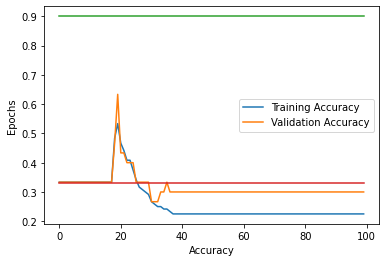

Training accuracy 0.225
Validation accuracy 0.3


In [11]:
model = FFNetwork(num_hidden=1)
model.fit(X_train, y_OH_train, epochs=100, eta=0.5)
print_accuracy()

Decreasing Learning Rate to check if the bias can be reduced.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


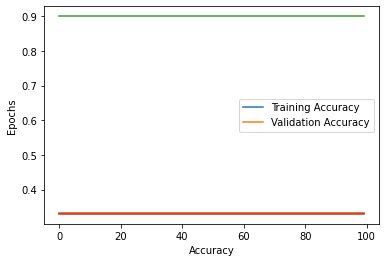

Training accuracy 0.3333
Validation accuracy 0.3333


In [12]:
model = FFNetwork(num_hidden=1)
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

Increasing the nuerons in the hidden layers to reduce the bias. As you increase the neurons, it is good to reduce Learning Rate and also train longer using more epochs, else there will be oscillations in Training and Validation Accuracy.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


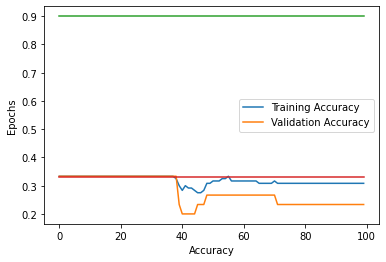

Training accuracy 0.3083
Validation accuracy 0.2333


In [13]:
model = FFNetwork(num_hidden=2)
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


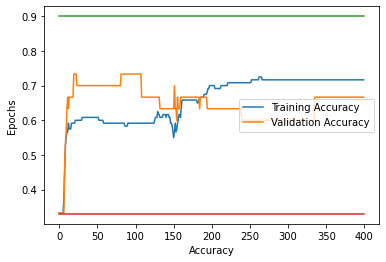

Training accuracy 0.7167
Validation accuracy 0.6667


In [14]:
model = FFNetwork(num_hidden=4)
model.fit(X_train, y_OH_train, epochs=400, eta=0.25)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


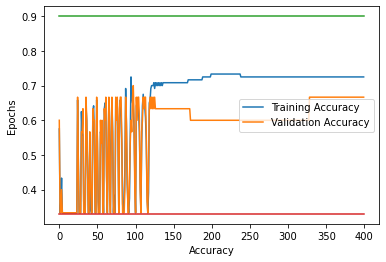

Training accuracy 0.725
Validation accuracy 0.6667


In [15]:
model = FFNetwork(num_hidden=4)
model.fit(X_train, y_OH_train, epochs=400, eta=1)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


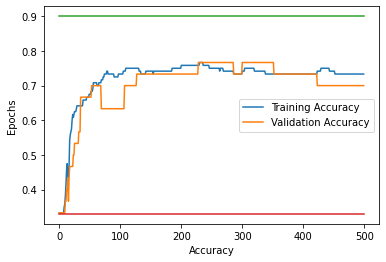

Training accuracy 0.7333
Validation accuracy 0.7


In [16]:
model = FFNetwork(num_hidden=8)
model.fit(X_train, y_OH_train, epochs=500, eta=0.1)
print_accuracy()

As you increase the neurons and make the model more complex, the variance increases. There will be larger difference in Training and Validation Accuracy.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


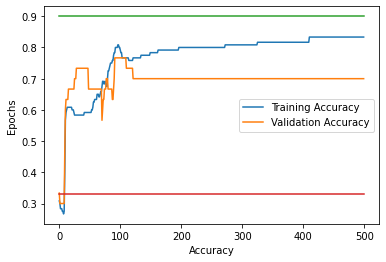

Training accuracy 0.8333
Validation accuracy 0.7


In [17]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


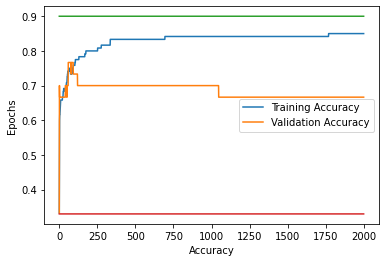

Training accuracy 0.85
Validation accuracy 0.6667


In [18]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1)
print_accuracy()

# Adding L2 Regularization

Increasing Lambda values increases Regularization. Larger lambda can cause Underfitting.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


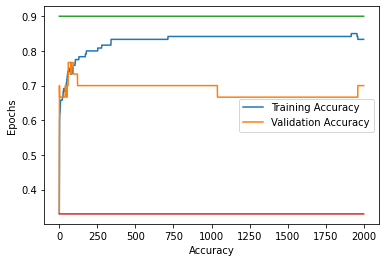

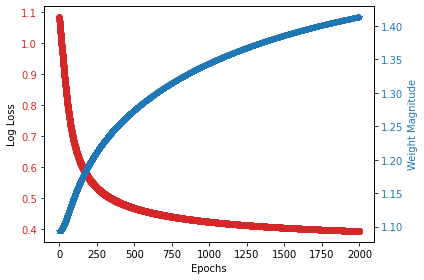

Training accuracy 0.8333
Validation accuracy 0.7


In [19]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm = True, lambda_val= 0.1, display_loss = True)
print_accuracy()

Weight magnitued increasing indicates that weights are taking more and more values far from 0. Larger weight indicates that the model is learning more and trying to fit to the data. Lambda decreases the Weight magnitude to decrease the weights and add regularization.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


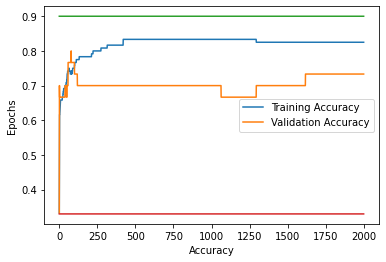

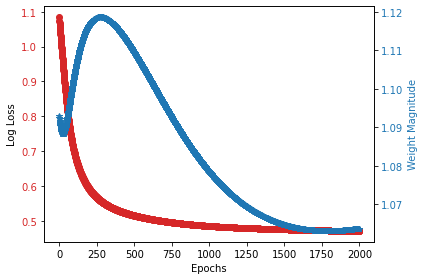

Training accuracy 0.825
Validation accuracy 0.7333


In [20]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm = True, lambda_val= 1, display_loss = True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


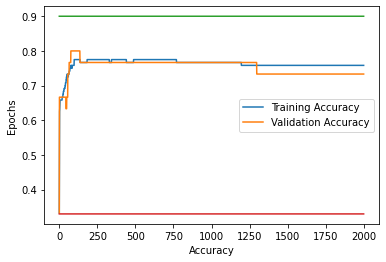

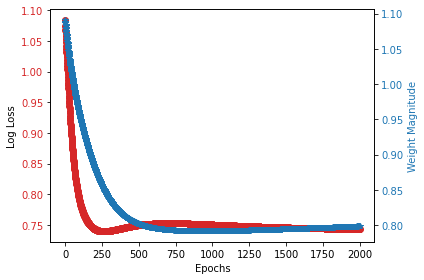

Training accuracy 0.7583
Validation accuracy 0.7333


In [21]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm = True, lambda_val= 5, display_loss = True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


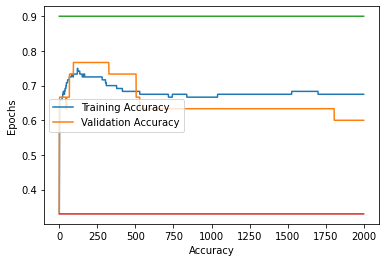

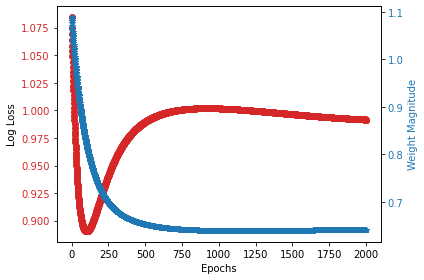

Training accuracy 0.675
Validation accuracy 0.6


In [22]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm = True, lambda_val= 10, display_loss = True)
print_accuracy()

# Adding Noise to Training Dataset

Modifying the location of input points in the Training dataset such that it's class is not changed to learn the model.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


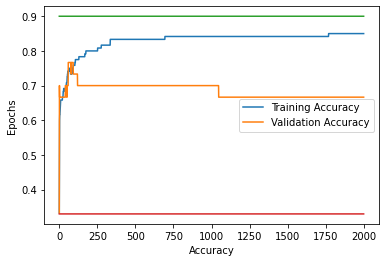

Training accuracy 0.85
Validation accuracy 0.6667


In [23]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm = False)
print_accuracy()

Noise fraction indicates how much % to shift the datapoints to obtain slightly modified locations of all the points. More noise fractions indicate more Regularization.

0.01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


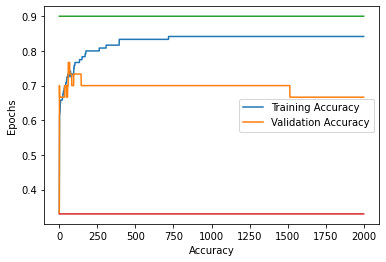

Training accuracy 0.8417
Validation accuracy 0.6667
0.05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


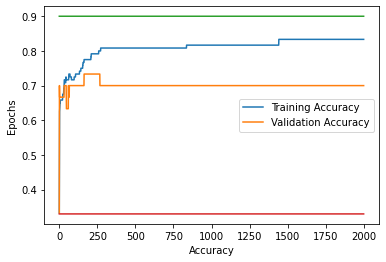

Training accuracy 0.8333
Validation accuracy 0.7
0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


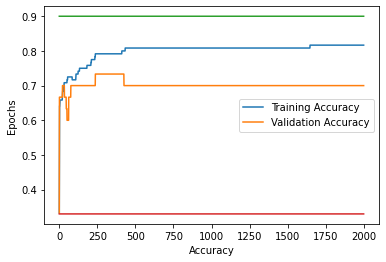

Training accuracy 0.8167
Validation accuracy 0.7
0.15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


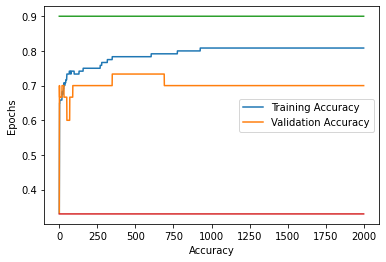

Training accuracy 0.8083
Validation accuracy 0.7
0.18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


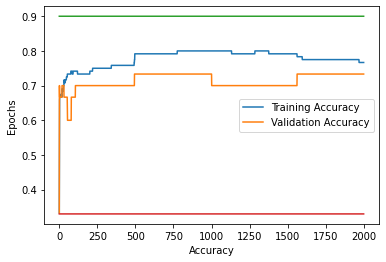

Training accuracy 0.7667
Validation accuracy 0.7333
0.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


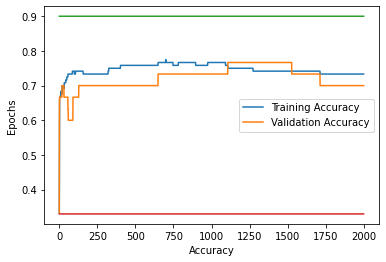

Training accuracy 0.7333
Validation accuracy 0.7


In [24]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
    print(noise_fraction)
    X_train_noisy = X_train * (1 - noise_fraction * np.random.randn(X_train.shape[0], X_train.shape[1] ))
    model = FFNetwork(num_hidden=64)
    model.fit(X_train_noisy, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
    print_accuracy()

# Early Stopping

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


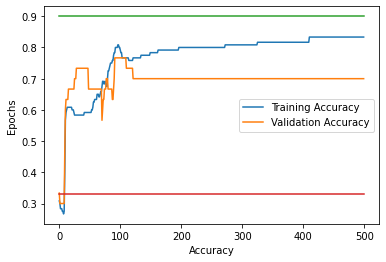

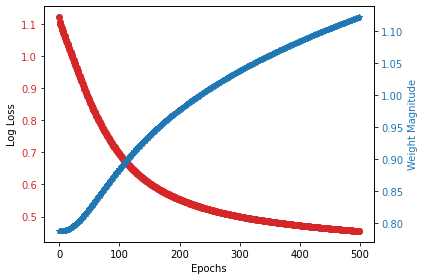

Training accuracy 0.8333
Validation accuracy 0.7


In [25]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=True)
print_accuracy()

In the above graph it is observed that, from 100 epochs onwards there is an increase in Variance. So to decrease overfitting, early stopping is introduced.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


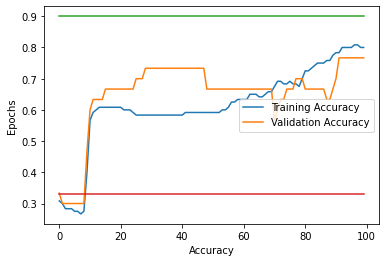

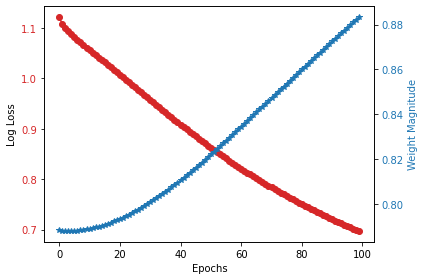

Training accuracy 0.8
Validation accuracy 0.7667


In [26]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=100, eta=0.2, display_loss=True)
print_accuracy()